# Purpose

# Imports

In [1]:
import autoreload
%load_ext autoreload
%autoreload 2

from src.data.make_dataset import transpose_columns

import pandas as pd
import numpy as np
import logging
logger = logging.getLogger()

import os
#os.chdir("work/python/notebooks") # go up to python/ level

import datetime as dt
import pytz

from io import BytesIO

import pickle
from googleapiclient.discovery import build

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Constants

In [2]:
# Token for plotly express mapbox viz
mapbox_token = open("../../secure_keys/public.mapbox_token").read()
px.set_mapbox_access_token(mapbox_token)

# Setup time stuff in consistent manner
TIME_FORMAT='%Y-%m-%d_%H:%M:%S'
TIMEZONE = pytz.timezone("UTC")

# Get logging formatted
LOG_FORMAT = '%(asctime)s: %(levelname)s (%(name)s) - %(message)s'

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(
    format=LOG_FORMAT,
    level=logging.INFO,
    datefmt='%m/%d/%Y %H:%M:%S')

# SBA Paycheck Protection Program Data



## Load Latest Cleaned File

Other members of the volunteer data scientist team are doing data cleaning of their own and pushing updates into a shared Google Drive, so let's get that first!

In [63]:
# Pull in our Google Drive creds
with open('secure_keys/token.pickle', 'rb') as token:
    creds = pickle.load(token)
    
service = build('drive', 'v3', credentials=creds)

In [82]:
# Find the info for All Data by State folder that contains raw PPP data
results = service.files().list(
    #fields="nextPageToken, files(id, name)",
q = "name = 'All Data by State'"
).execute()
data_folder_info = results.get('files', [])[0] # just access results dict with 'files' key or returns [] if key not there
data_folder_info

{'kind': 'drive#file',
 'id': '1uuO0075wElCtZVqk9HaUWPCxizohc0L9',
 'name': 'All Data by State',
 'mimeType': 'application/vnd.google-apps.folder'}

In [73]:
# Find the child folders in the All Data by State folder
results = service.files().list(
q = f"'{data_folder_info['id']}' in parents and mimeType = 'application/vnd.google-apps.folder'").execute()
data_subfolders = results.get('files', []) # just access results dict with 'files' key or returns [] if key not there
data_subfolders

[{'kind': 'drive#file',
  'id': '1g92YGs6BD40S89CqRZhlL2XXPQE-JIR8',
  'name': 'Wyoming',
  'mimeType': 'application/vnd.google-apps.folder'},
 {'kind': 'drive#file',
  'id': '19OOYSCuzi2jGJXUBMb8EDtfUxjRW8NyN',
  'name': 'Vermont',
  'mimeType': 'application/vnd.google-apps.folder'},
 {'kind': 'drive#file',
  'id': '1LCRqy05NV8nwaOg-YJOnt0ueow0WFJNq',
  'name': 'Virginia',
  'mimeType': 'application/vnd.google-apps.folder'},
 {'kind': 'drive#file',
  'id': '1XVK0rzn9DteU5Jg5rMootujPKzyfP5bS',
  'name': 'Wisconsin',
  'mimeType': 'application/vnd.google-apps.folder'},
 {'kind': 'drive#file',
  'id': '1NJNG2ewGUrela4JCNZOeq-rCs5WNX-RT',
  'name': 'Washington',
  'mimeType': 'application/vnd.google-apps.folder'},
 {'kind': 'drive#file',
  'id': '1rUua0BiZFioslEY-LJJMXglGIdFMzGly',
  'name': 'Virgin Islands',
  'mimeType': 'application/vnd.google-apps.folder'},
 {'kind': 'drive#file',
  'id': '1NeT6s5LznLXYTlyY1Z-jLuTGXFzQVLOk',
  'name': 'Utah',
  'mimeType': 'application/vnd.google-apps

In [76]:
# Find all CSV files in the child folders
data_subfolder_ids = []

# Get the subfolder IDs
for subfolder in data_subfolders:
    data_subfolder_ids.append(subfolder['id'])
    
data_subfolder_ids

['1g92YGs6BD40S89CqRZhlL2XXPQE-JIR8',
 '19OOYSCuzi2jGJXUBMb8EDtfUxjRW8NyN',
 '1LCRqy05NV8nwaOg-YJOnt0ueow0WFJNq',
 '1XVK0rzn9DteU5Jg5rMootujPKzyfP5bS',
 '1NJNG2ewGUrela4JCNZOeq-rCs5WNX-RT',
 '1rUua0BiZFioslEY-LJJMXglGIdFMzGly',
 '1NeT6s5LznLXYTlyY1Z-jLuTGXFzQVLOk',
 '1y9S9t8zVdazAjiqQQJMvC6vJcpqn940e',
 '1ujNT5X0T8HyXWIgSgmyOACqLjb7lIRfz',
 '1qlt355n6bPlpXgb0e65PVwliRiPQX_Z1',
 '1Gea62RaeWCFVRFv0SdNtTE1URaU1YCPN',
 '1xbGhYS-kfBp2sePhquDU8fy7Wy8Vm8Kn',
 '1lMJJjNh_MKXRWpkyt4YDsyJfPBu06hNM',
 '1tYblyYoqg-ggsHvrjTvJ2ntFiMr0pY4M',
 '11iQjkDi6HT2YengU3beDzgbuHZk9LQhj',
 '12vf4_vOxS3HScnP5Ba9GMoiGECLuKD7A',
 '17gkIBQe2eAcCkRKeJ0FSxvQGVFsEmpqU',
 '1s2nsIS6j7Vt2pdiTmFk7O5EI0ybRosqM',
 '1TSry8Gw8yy9JhWTX2W8sqRiYUd3MjdM-',
 '1r1NnJlUJmDVhX0ecdxfizr9BwbZH0rI5',
 '1e2hVMMlyWHs1podHUsA2sbyrK8TGv-B4',
 '121M-DDixDLNXy43bu-dKNpIHR8pEDKas',
 '1UR8CofrtH8EFMPSf7chIlSKjkCxWSacY',
 '1waA32WjdtBktdDUi4ECcbDHae2zSGeog',
 '1VfG6425yIcUKXhJqG-DuooheYmGd_l_-',
 '1CioK5rO3ytUg82ViytlegaNpGy-8UqyW',
 '1q3ktB6faZ

In [86]:
query = " in parents or ".join([f"'{folder_id}'" for folder_id in data_subfolder_ids])
query += " in parents"
query = f"({query})"
query +=  "and mimeType = 'text/csv'"

In [ ]:
# Get all CSV file IDs from data subfolders as a list of ByteStrings
data_file_ids = service.files().list(
q = query).execute().get('files', []) 


# Pull and concatenate all ByteStrings, skipping headers, 
# and decode into single DataFrame for further analysis
# Note that this would be more efficient long-term to ZIP all CSVs into one file 
# and then pull that down alone
for i, file in enumerate(data_file_ids):
    if i == 0:
        data_str = service.files()\
        .get_media(fileId=file['id'])\
        .execute()
        
    # just concatenating here, without header, since we already have it
    else:
        temp_data_str = service.files()\
        .get_media(fileId=file['id'])\
        .execute()
        
        # Assuming here that header is the same across files and thus we can skip it
        # Find end of header by finding first newline character
        data_start_index = temp_data_str.find(b"\n") + 1

        data_str += temp_data_str[data_start_index:]
        # Check that \r\n is at end of string, add it if not
        if data_str[-2:] != b'\r\n':
            data_str += b'\r\n'

# Decode ByteString into something that pandas can make a DataFrame out of
data = data_str.decode('utf8').encode('latin-1')
df = pd.read_csv(BytesIO(data), encoding='latin-1', low_memory=False)

df.info(memory_usage='deep')

### All Together Now!

In [2]:
%%time
from src.data.make_dataset import pull_ppp_data

df = pull_ppp_data(local_copy='/home/jovyan/work/data/raw/unprocessed_ppp_data.csv')
df.info(memory_usage='deep')

100%|██████████| 58/58 [02:23<00:00,  2.47s/it]
/opt/conda/envs/CARES_Act/lib/python3.7/site-packages/IPython/core/magic.py:187: DtypeWarning: Columns (0,3,4,5,6,10,12,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4885388 entries, 0 to 4885387
Data columns (total 16 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   LoanRange      object
 1   BusinessName   object
 2   Address        object
 3   City           object
 4   State          object
 5   Zip            object
 6   NAICSCode      object
 7   BusinessType   object
 8   RaceEthnicity  object
 9   Gender         object
 10  Veteran        object
 11  NonProfit      object
 12  JobsRetained   object
 13  DateApproved   object
 14  Lender         object
 15  CD             object
dtypes: object(16)
memory usage: 596.4+ MB
CPU times: user 2min 55s, sys: 55.3 s, total: 3min 50s
Wall time: 8min 14s


In [5]:
%%time
# If you've already saved a local copy...
df = pd.read_csv('../data/raw/unprocessed_ppp_data.csv')
df.info(memory_usage='deep')

<string>:2: DtypeWarning: Columns (0,3,4,5,6,10,12,14,15) have mixed types.Specify dtype option on import or set low_memory=False.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4885388 entries, 0 to 4885387
Data columns (total 16 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   LoanRange      object
 1   BusinessName   object
 2   Address        object
 3   City           object
 4   State          object
 5   Zip            object
 6   NAICSCode      object
 7   BusinessType   object
 8   RaceEthnicity  object
 9   Gender         object
 10  Veteran        object
 11  NonProfit      object
 12  JobsRetained   object
 13  DateApproved   object
 14  Lender         object
 15  CD             object
dtypes: object(16)
memory usage: 3.9 GB
CPU times: user 32.8 s, sys: 4.26 s, total: 37 s
Wall time: 46.9 s


In [4]:
# What is that NAICS code?
naics = pd.read_csv('../../data/Lookup Tables/NAICS Codes.csv',
                    usecols=['NAICS', 'Industry'],
                   encoding='latin-1')
naics.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2196 entries, 0 to 2195
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   NAICS     2196 non-null   object
 1   Industry  2196 non-null   object
dtypes: object(2)
memory usage: 336.4 KB


## Determining Patterns to Bad Data

There are [a number of documented issues](https://qz.com/1878225/heres-what-we-know-is-wrong-with-the-ppp-data/) with the PPP dataset and I have a sneaking suspicion that the problems correlate with lender name to a large extent (e.g. a single lender tended to put ZIP codes in the State section of the data). Let's see if that plays out at all.

### States Column

This one should be easy to check, with two-letter abbreviations (that are well-established) being the expectation.

In [4]:
# First memory_usage=es = 87,689 CA counts as top
df['State'].value_counts()

722511.0    135496
531210.0    110875
541110.0    107600
621210.0     88677
CA           87689
             ...  
335220           1
813940           1
313220           1
233110           1
315233.0         1
Name: State, Length: 2170, dtype: int64

In [6]:
# Is there any obvious pattern to the (loan amount?) being in the State field? E.g. by lender?
df[df['State'] == 722511.0]

,LoanRange,BusinessName,Address,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD
688136,135913,CITY OF INDUSTRY,CA,91748,722511,Corporation,Unanswered,Unanswered,Unanswered,NaN,33,05/17/2020,"Bank of America, National Association",CA - 32,NaN,NaN
688157,135900,SAN FRANCISCO,CA,94107,722511,Corporation,Unanswered,Unanswered,Unanswered,NaN,NaN,06/09/2020,GBC International Bank,CA - 01,NaN,NaN
688175,135870,SAN DIEGO,CA,92111,722511,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,10,04/14/2020,"JPMorgan Chase Bank, National Association",CA - 52,NaN,NaN
688176,135870,OAKLAND,CA,94611,722511,Corporation,Unanswered,Unanswered,Unanswered,NaN,11,05/03/2020,"U.S. Bank, National Association",CA - 11,NaN,NaN
688201,135800,EL CENTRO,CA,92243,722511,Corporation,Hispanic,Male Owned,Non-Veteran,NaN,14,04/10/2020,Community Valley Bank,CA - 51,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4885092,500,MONTEZUMA,GA,31063,722511,Partnership,Unanswered,Unanswered,Unanswered,NaN,NaN,06/26/2020,Truist Bank d/b/a Branch Banking & Trust Co,GA - 02,NaN,NaN
4885160,421,DULUTH,GA,30096,722511,Corporation,Unanswered,Unanswered,Unanswered,NaN,0,05/08/2020,"Wells Fargo Bank, National Association",GA - 07,NaN,NaN
4885251,260,DEARING,GA,30808,722511,Sole Proprietorship,Unanswered,Unanswered,Unanswered,NaN,0,05/07/2020,Regions Bank,GA - 10,NaN,NaN
4885312,133,SUWANEE,GA,30024,722511,Corporation,Unanswered,Unanswered,Unanswered,NaN,3,05/08/2020,"Bank of America, National Association",GA - 06,NaN,NaN


In [21]:
naics[naics['NAICS'] == '722511']

,NAICS,Industry
2019,722511,Full-Service Restaurants


In [22]:
# Consistent across lenders maybe?
df.loc[df['State'] == 722511.0, 'JobsRetained'].value_counts()

count    4062.000000
mean       33.356967
std       234.258549
min         1.000000
25%         3.000000
50%         7.000000
75%        17.000000
max      9562.000000
Name: JobsRetained, dtype: float64

In [44]:
lender_value_counts = df.loc[df['State'] == 722511.0, 'JobsRetained'].value_counts().reset_index()
lender_value_counts.rename(columns={
    'index': 'Lender',
    'JobsRetained': 'count'
}, inplace=True)


lender_value_counts[lender_value_counts['count'] > 100]

,Lender,count
0,"Bank of America, National Association",9562
1,"JPMorgan Chase Bank, National Association",5852
2,"Wells Fargo Bank, National Association",5820
3,Truist Bank d/b/a Branch Banking & Trust Co,2895
4,"U.S. Bank, National Association",2588
...,...,...
172,ConnectOne Bank,105
173,Premier Bank,105
174,Dime Community Bank,105
175,1st Source Bank,102


In [49]:
lender_value_counts['count'].describe()

count    4062.000000
mean       33.356967
std       234.258549
min         1.000000
25%         3.000000
50%         7.000000
75%        17.000000
max      9562.000000
Name: count, dtype: float64

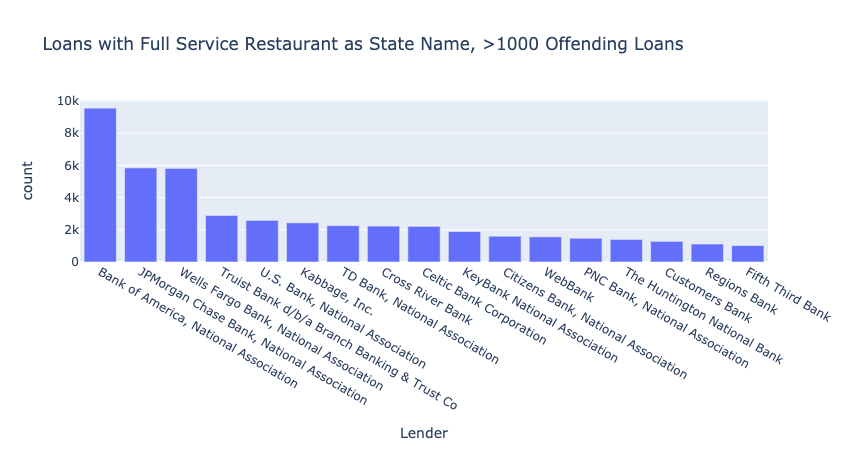

In [50]:
px.bar(lender_value_counts[lender_value_counts['count'] > 1000],
      x='Lender', y='count', title='Loans with Full Service Restaurant as State Name, >1000 Offending Loans')

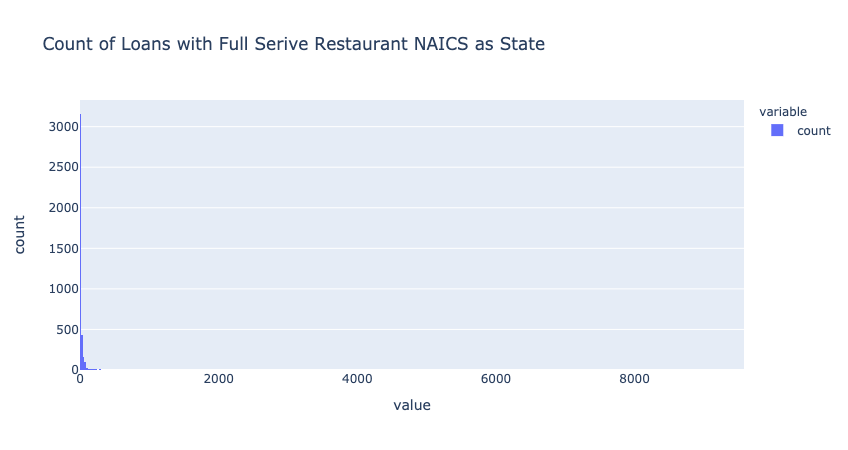

In [53]:
px.histogram(lender_value_counts['count'], title='Count of Loans with Full Serive Restaurant NAICS as State')

So it's not reasonable to say that this corresponds directly to specific lenders, but it is certainly suspicious nonetheless.

This appears to have every entry offset by two columns to the left (e.g. `City` entry appears in the `BusinessName` column. As such, the value we filtered by (`df['State'] == 722511.0`) is actually the NAICS code, which corresponds to "Full-Service Restaurants".

Oddly enough, **`LoanRange`** seems to be correct (as it *should* be `Address` value if the shifting of columns was kept consistent). Not sure why.

In [58]:
# What about other values in the State column?
# Expect that NaNs will be ignored here and generated by non-string entries
df['State'].str.len().describe()

count    687596.000000
mean          2.153451
std           0.768281
min           2.000000
25%           2.000000
50%           2.000000
75%           2.000000
max           6.000000
Name: State, dtype: float64

In [23]:
# Are all of the numeric entries in the 1E5 scale?
only_numeric_states = df[df['State'].apply(np.isreal)]
print(f"There are {len(only_numeric_states) / len(df) * 100}% of loans with a numeric State value")

There are 85.92545771185421% of loans with a numeric State value


In [64]:
# What does the distribution look like of these numeric values?
only_numeric_states['State'].astype(float).describe()

count    4.071048e+06
mean     5.444168e+05
std      1.890994e+05
min      1.111100e+05
25%      4.471100e+05
50%      5.413200e+05
75%      6.244100e+05
max      9.999900e+05
Name: State, dtype: float64

Given that these are all in the range 100,000 to 999,000, it seems likely that they're all NAICS codes. Let's do one more check on the possibility that these are all transposed by 2 columns: if `BusinessType` (which should map to the well-defined `Gender` column) has only the gender values we expect.

In [65]:
only_numeric_states['BusinessType'].value_counts()

Unanswered      3305851
Male Owned       676576
Female Owned     215365
Name: BusinessType, dtype: int64

That settles it: if the State is a numeric value, it's off by 2 columns everywhere EXCEPT the `LoanRange`. Let's flag it and then fix it!

In [26]:
# Check to see what data are in the two columns that State-based transposition is pushing out
only_numeric_states[['Lender', 'CD']].isnull().count() / len(only_numeric_states)

2020-08-17 16:00:39,102 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.


Lender    1.0
CD        1.0
dtype: float64

OK, nothing is being lost if we overwrite those last two columns with the transposed data from columns to the left. Great!

In [21]:
4 not in l

True

In [24]:
%%time
# Fix bad state data
from src.data.make_dataset import clean_ppp_data

test = clean_ppp_data(df)
test['State'].value_counts()

Finding the rows in which numeric values exist for the State column...: 100%|██████████| 4885388/4885388 [00:28<00:00, 169685.41it/s]
2020-08-17 18:24:33,274 - root - INFO - 86.46539435557627% of the loans have a numeric State value


problem_fix_columns = Index([], dtype='object')
frozen_columns = ['LoanRange']
frozen_columns = ['LoanRange']


2020-08-17 18:24:46,183 - root - INFO - Note that 'AE' is an abbreviation for the 'state' of Armed Forces - Europe. It's valid.


CPU times: user 39.4 s, sys: 6.39 s, total: 45.8 s
Wall time: 50.1 s


CA    581125
FL    393017
TX    389387
NY    323900
IL    202157
PA    165909
GA    156810
NJ    147548
OH    140278
NC    121913
MI    121137
MA    112996
VA    109227
CO    104403
WA    101051
MN     98136
TN     93287
MO     91494
WI     85459
MD     81317
AZ     81011
IN     79147
LA     73827
AL     65803
OK     64278
SC     63168
OR     62775
CT     60948
IA     58463
KS     51873
UT     50691
KY     48370
MS     45814
NE     42497
AR     42433
NV     42147
PR     37836
ID     30168
ME     27198
HI     24533
NH     23829
MT     23102
SD     22507
NM     21927
ND     19724
WV     17325
RI     17163
WY     13229
DE     12504
DC     12484
VT     11929
AK     11167
GU      2164
VI      1896
MP       473
AS       223
XX       210
AE         1
Name: State, dtype: int64

In [25]:
test['StateCol_Transposition_Problem'].value_counts()

1    4224170
0     661218
Name: StateCol_Transposition_Problem, dtype: int64

In [26]:
test['StateCol_Transposition_Problem_Fixed'].value_counts()

1    4224170
0     661218
Name: StateCol_Transposition_Problem_Fixed, dtype: int64

Fantastic! This seems to have done the trick, although the XX entries are a bit of a mystery (the last 4 are all territories, btw).

In [35]:
test[test['State'] == 'XX']

,LoanRange,BusinessName,Address,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD
661202,"d $350,000-1 million",AERO BOX LLC,NaN,NaN,XX,NaN,484210,NaN,Unanswered,Unanswered,Unanswered,NaN,NaN,05/03/2020,The Huntington National Bank,NA -
661203,"d $350,000-1 million",BOYER CHILDREN'S CLINIC,1850 BOYER AVE E,SEATTLE,XX,98112,NaN,Non-Profit Organization,Unanswered,Unanswered,Unanswered,Y,75,05/03/2020,"Bank of America, National Association",WA - 07
661204,"d $350,000-1 million",KIRTLEY CONSTRUCTION INC,1661 MARTIN RANCH RD,SAN BERNARDINO,XX,92407,236115,Corporation,Unanswered,Unanswered,Unanswered,NaN,21,05/03/2020,"Bank of America, National Association",CA - 08
661205,"d $350,000-1 million","PLEASANT PLACES, INC.",7684 Southrail Road,NORTH CHARLESTON,XX,29420,561730,Sole Proprietorship,Unanswered,Male Owned,Non-Veteran,NaN,73,05/03/2020,Synovus Bank,SC - 01
661206,"d $350,000-1 million","SUMTER COATINGS, INC.",2410 Highway 15 South,SUMTER,XX,29150,325510,Corporation,Unanswered,Unanswered,Unanswered,NaN,62,05/03/2020,Synovus Bank,SC - 05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3811029,0,NaN,NaN,NaN,XX,NaN,339114,NaN,Unanswered,Unanswered,Unanswered,NaN,NaN,05/03/2020,Celtic Bank Corporation,NA -
3811030,0,NaN,NaN,NaN,XX,NaN,339114,NaN,Unanswered,Unanswered,Unanswered,NaN,NaN,05/03/2020,Celtic Bank Corporation,NA -
3811031,0,NaN,NaN,NaN,XX,NaN,339114,NaN,Unanswered,Unanswered,Unanswered,NaN,NaN,05/03/2020,Celtic Bank Corporation,NA -
3811032,0,NaN,NaN,NaN,XX,NaN,339114,NaN,Unanswered,Unanswered,Unanswered,NaN,NaN,05/03/2020,Celtic Bank Corporation,NA -


### Categorical Columns

Gender, BusinessType, RaceEthnicity, Veteran, NonProfit

In [28]:
# What does a correct record look like?
good_record = test[(test['Gender'] == 'Female Owned') & \
  (test['NonProfit'] == 'Y')].iloc[0]

good_record

LoanRange                                     d $350,000-1 million
BusinessName                                   EASTER SEALS ALASKA
Address                                 670 W. Fireweed Ln. STE201
City                                                     ANCHORAGE
State                                                           AK
Zip                                                          99503
NAICSCode                                                   813219
BusinessType                               Non-Profit Organization
RaceEthnicity                                             Hispanic
Gender                                                Female Owned
Veteran                                                Non-Veteran
NonProfit                                                        Y
JobsRetained                                                    92
DateApproved                                            04/27/2020
Lender                                  Neighborhood National 

In [29]:
# Look at value counts across them all first, 
# to get a flavor of what we're dealing with and help with debugging
categorical_columns = [
    "Gender",
    "BusinessType",
    "RaceEthnicity",
    "Veteran",
    "NonProfit"
]

for column in categorical_columns:
    print(f"Column: {column}")
    print("\n")
    print(test[column].value_counts())
    print("\n\n\n")

Column: Gender


Unanswered      3795164
Male Owned       841727
Female Owned     248497
Name: Gender, dtype: int64




Column: BusinessType


Corporation                            1418759
Limited  Liability Company(LLC)        1410562
Subchapter S Corporation                721654
Sole Proprietorship                     714743
Non-Profit Organization                 179088
Self-Employed Individuals               174136
Independent Contractors                 122630
Partnership                              71037
Limited Liability Partnership            32973
Professional Association                 22855
Cooperative                               6479
Non-Profit Childcare Center               2592
Trust                                     1213
Employee Stock Ownership Plan(ESOP)        836
Joint Venture                              569
Tenant in Common                           516
Rollover as Business Start-Ups (ROB         23
Name: BusinessType, dtype: int64




Column: RaceEthnicity

Awesome! None of these seem to be problematic, so let's make them categoricals to save on memory and move on.

In [38]:
categorical_columns = [
    'BusinessName', 'City', 'State', 'Zip',
       'NAICSCode', 'BusinessType', 'RaceEthnicity', 'Gender', 'Veteran',
       'NonProfit', 'JobsRetained', 'DateApproved', 'Lender', 'CD'
]

for column in categorical_columns:
    print(f"Fraction unique {column} values relative to all values = {test[column].nunique() / len(test)}")

Fraction unique BusinessName values relative to all values = 0.1343991511012022
Fraction unique City values relative to all values = 0.007701333036393425
Fraction unique State values relative to all values = 1.1872137893653482e-05
Fraction unique Zip values relative to all values = 0.007918920667099523
Fraction unique NAICSCode values relative to all values = 0.00044888962759969113
Fraction unique BusinessType values relative to all values = 3.4797645550363656e-06
Fraction unique RaceEthnicity values relative to all values = 1.8422282938427818e-06
Fraction unique Gender values relative to all values = 6.14076097947594e-07
Fraction unique Veteran values relative to all values = 6.14076097947594e-07
Fraction unique NonProfit values relative to all values = 2.0469203264919797e-07
Fraction unique JobsRetained values relative to all values = 0.0001621160898581648
Fraction unique DateApproved values relative to all values = 1.617067057928664e-05
Fraction unique Lender values relative to all 

As none of these come even close to 80% of the total column size (which is a rough cutoff I'm using to say that these are not categorical), the largest being `BusinessName` at 13%, I think we can safely make these all categorical!

In [34]:
# Make these categorical variables into efficiently-stored categoricals
test[categorical_columns].astype('category')

,Gender,BusinessType,RaceEthnicity,Veteran,NonProfit
0,Unanswered,Non-Profit Organization,Unanswered,Unanswered,Y
1,Unanswered,Subchapter S Corporation,Unanswered,Unanswered,NaN
2,Unanswered,Corporation,Unanswered,Unanswered,NaN
3,Unanswered,Limited Liability Company(LLC),Unanswered,Unanswered,NaN
4,Unanswered,Cooperative,Unanswered,Unanswered,NaN
...,...,...,...,...,...
4885383,Unanswered,Limited Liability Company(LLC),Unanswered,Unanswered,NaN
4885384,Unanswered,Limited Liability Company(LLC),Unanswered,Unanswered,NaN
4885385,Unanswered,Sole Proprietorship,Unanswered,Unanswered,NaN
4885386,Unanswered,Corporation,Unanswered,Unanswered,NaN


In [42]:
%%time
# How do things speed up with cat vs. non-cat, if at all?
# Non-cat
test['State'].value_counts()

# 1.34 seconds wall time

CPU times: user 1.3 s, sys: 24.8 ms, total: 1.32 s
Wall time: 1.34 s


CA    581125
FL    393017
TX    389387
NY    323900
IL    202157
PA    165909
GA    156810
NJ    147548
OH    140278
NC    121913
MI    121137
MA    112996
VA    109227
CO    104403
WA    101051
MN     98136
TN     93287
MO     91494
WI     85459
MD     81317
AZ     81011
IN     79147
LA     73827
AL     65803
OK     64278
SC     63168
OR     62775
CT     60948
IA     58463
KS     51873
UT     50691
KY     48370
MS     45814
NE     42497
AR     42433
NV     42147
PR     37836
ID     30168
ME     27198
HI     24533
NH     23829
MT     23102
SD     22507
NM     21927
ND     19724
WV     17325
RI     17163
WY     13229
DE     12504
DC     12484
VT     11929
AK     11167
GU      2164
VI      1896
MP       473
AS       223
XX       210
AE         1
Name: State, dtype: int64

In [6]:
%%time
# Fix bad state data
from src.data.make_dataset import clean_ppp_data

test = clean_ppp_data(df)

/opt/conda/envs/CARES_Act/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
Finding the rows in which numeric values exist for the State column...: 100%|██████████| 4885388/4885388 [00:24<00:00, 198407.15it/s]
2020-08-18 02:42:51,147 - root - INFO - 86.46539435557627% of the loans have a numeric State value. This will be corrected.
2020-08-18 02:42:58,928 - root - INFO - Note that 'AE' is an abbreviation for the 'state' of Armed Forces - Europe. It's valid.
2020-08-18 02:42:59,573 - root - INFO - Setting cleaned categorical data to categorical dtype.


CPU times: user 51.8 s, sys: 7.49 s, total: 59.3 s
Wall time: 59.6 s


In [7]:
%%time
# How do things speed up with cat vs. non-cat, if at all?
# With-cat
test['State'].value_counts()

# 27.1 ms wall time...so that's 49x faster...

CPU times: user 24.2 ms, sys: 2.97 ms, total: 27.2 ms
Wall time: 27.1 ms


CA    581125
FL    393017
TX    389387
NY    323900
IL    202157
PA    165909
GA    156810
NJ    147548
OH    140278
NC    121913
MI    121137
MA    112996
VA    109227
CO    104403
WA    101051
MN     98136
TN     93287
MO     91494
WI     85459
MD     81317
AZ     81011
IN     79147
LA     73827
AL     65803
OK     64278
SC     63168
OR     62775
CT     60948
IA     58463
KS     51873
UT     50691
KY     48370
MS     45814
NE     42497
AR     42433
NV     42147
PR     37836
ID     30168
ME     27198
HI     24533
NH     23829
MT     23102
SD     22507
NM     21927
ND     19724
WV     17325
RI     17163
WY     13229
DE     12504
DC     12484
VT     11929
AK     11167
GU      2164
VI      1896
MP       473
AS       223
XX       210
AE         1
Name: State, dtype: int64

In [8]:
!ls ../data

external  interim  processed  raw


In [10]:
# Write the cleaned file
test.to_csv("../data/processed/ppp_data_cleaned_python.csv", index=False)

### CD (Congressional District) Column

### JobsRetained Column

### DateApproved Column

### Zip Column

### City Column